In [1]:
## Accelerate version
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import distance
import time


# reproducibility
np.random.seed(10)
# Base vectors (assume known)
a = np.array([np.sqrt(3)/2, 1/2])  # Example base vector a
b = np.array([np.sqrt(3)/2, -1/2])  # Example base vector b, forming a 60-degree angle with a
M, N = 500, 1  # M emitters, N measurements
sigma = 0.1

# True positions of the balls in terms of grid indices (for simulation purposes)
value_range = 30  # The range of values for each element in the pairs# Generate all possible unique pairs
all_pairs = [(i, j) for i in range(1, value_range + 1) for j in range(1, value_range + 1)]# Shuffle the list of all pairs to randomize
np.random.shuffle(all_pairs)# Select M unique pairs
selected_pairs = all_pairs[:M]# Convert to a NumPy array
grid_indices = np.array(selected_pairs).astype(float)
# Generate new measurement
# True positions in Cartesian coordinates before applying T and U
p = np.array([grid_indices[i, 0]*a + grid_indices[i, 1]*b for i in range(M)])
# True rotation angle theta and offset U (for simulation)
theta_true = np.pi/12  # 30 degrees
U_true = np.array([0.5, 0.2])

# Simulate measurements with true T(theta_true) and U
T_true = np.array([[np.cos(theta_true), -np.sin(theta_true)], [np.sin(theta_true), np.cos(theta_true)]])

positions_labspace = np.array([T_true @ p[i] + U_true for i in range(M)])
# measurements = np.random.normal(positions_labspace,sigma)

# # Pre-compute lattice positions for a range of m and n
m_n_range = 2  # Adjust based on expected lattice size
lattice_positions = {}
for m in range(-m_n_range, m_n_range + 1):
    for n in range(-m_n_range, m_n_range + 1):
        lattice_positions[(m, n)] = m * a + n * b

def compute_position(m,n, theta, U, a, b):
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.dot(R, (m * a + n * b)) + U

# # Function to match measured positions to the closest pre-computed lattice position
def match_to_lattice(theta, U, position):
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    min_dist = np.ones([M,1])*np.inf
    best_m_n = np.zeros([M,2])
    for (m, n), lattice_pos in lattice_positions.items():
        rotated_translated_pos = np.tile((np.dot(R, lattice_pos) + U),(M,1))
        square_diff = (rotated_translated_pos - position) **2
        dist = np.sqrt(np.sum(square_diff,axis=1)).reshape((M,1))
        mask = dist < min_dist
        min_dist[mask] = dist[mask]
        mask = mask.flatten()
        best_m_n[mask] = np.array([m,n])
    return best_m_n

# # Modified log-likelihood function that uses match_to_lattice
def log_likelihood(params):
    theta= params[0]
    u_x = params[1]
    u_y = params[2]
    U = np.array([u_x, u_y])
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ll = 0
    v_beforeOffset = (measurements - U)
    vector = np.matmul(R.T, v_beforeOffset.T).T
    # vector = np.transpose(vector).reshape(M,N,2)
    m_max = np.round(2/3*(2*np.dot(vector,a)-np.dot(vector,b))).reshape((M,1))
    n_max = np.round(2/3*(2*np.dot(vector,b)-np.dot(vector,a))).reshape((M,1))
    # vector_AroundOrigin = vector - (m_max * np.transpose(a) + n_max * np.transpose(b));
    vector_AroundOrigin = measurements - (np.matmul(R,(m_max * a + n_max * b).T).T);
    #Relocate to the origin to find the max integer of m and n pair
    best_m_n = match_to_lattice(theta, U, vector_AroundOrigin)
    for i in range(M):
        predicted_position = compute_position(*best_m_n[i,:], theta, U, a, b)
        local_ll = np.sum((predicted_position - vector_AroundOrigin[i, :])**2)
        ll += -local_ll*100
    return -ll

# Optimization
initial_guess = [0.25, 0.2, 0.1]  # Initial guess for theta, u_x, u_y
    # Constraint for Uy
def constraint_uy(params):
    _, ux, uy = params
    return np.abs(ux)/np.sqrt(3) - np.abs(uy)

constraints = [{'type': 'ineq', 'fun': constraint_uy}]  # Constraints setup
bounds = [(0, np.pi/3), (0, np.sqrt(3)/2), (-0.5, 0.5)]  # Bounds for theta, Ux
result = []
for i in range(N):

  measurements = np.random.normal(positions_labspace,sigma)
  # measurements = positions_labspace
  result.append(minimize(log_likelihood, initial_guess, method = 'SLSQP',bounds = bounds,constraints=constraints))

# theta_opt, u_x_opt, u_y_opt = result.x


In [2]:
from multiprocessing import Pool

import numpy as np

import time

from datetime import datetime



# reproducibility

np.random.seed(10)

# Base vectors (assume known)



# define all ground truth values

a = np.array([np.sqrt(3)/2, 1/2])  # Example base vector a

b = np.array([np.sqrt(3)/2, -1/2])  # Example base vector b, forming a 60-degree angle with a



# True rotation angle theta and offset U (for simulation)

theta_true = np.pi/12  # 30 degrees

U_true = np.array([0.5, 0.2])

# Simulate measurements with true T(theta_true) and U

T_true = np.array([[np.cos(theta_true), -np.sin(theta_true)], [np.sin(theta_true), np.cos(theta_true)]])



def generate_new_emitter_location(M):

    value_range = 100

    # True positions of the balls in terms of grid indices (for simulation purposes)

    all_pairs = [(i, j) for i in range(1, value_range + 1) for j in range(1, value_range + 1)]# Shuffle the list of all pairs to randomize

    np.random.shuffle(all_pairs)# Select M unique pairs

    selected_pairs = all_pairs[:M]# Convert to a NumPy array

    grid_indices = np.array(selected_pairs).astype(float)

    p = np.array([grid_indices[i, 0]*a + grid_indices[i, 1]*b for i in range(M)])

    # Simulate measurements with true T(theta_true) and U

    positions_labspace = np.array([T_true @ p[i] + U_true for i in range(M)])

    return positions_labspace



def compute_position(best_m_n, theta, U):

    M = best_m_n.shape[0]

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    # best_m_n is Mx2

    assert best_m_n.shape == (M, 2), print(best_m_n.shape)

    lattice_points_in_lattice_space = best_m_n[:, 0:1]* a + best_m_n[:, 1:] * b

    assert lattice_points_in_lattice_space.shape == (M, 2)

    return np.dot(R, lattice_points_in_lattice_space.reshape((2, -1))).T + U



### Match lattice

m_n_range = 2  # Adjust based on expected lattice size



Ms, Ns = np.meshgrid(np.arange(-m_n_range, m_n_range + 1), np.arange(-m_n_range, m_n_range + 1))

Ms = Ms.flatten().reshape(-1, 1)

Ns = Ns.flatten().reshape(-1, 1)

lattice_positions = Ms * a + Ns * b

lattice_positions = lattice_positions.reshape(1, 2*m_n_range+1, 2*m_n_range+1, 2)

assert lattice_positions.shape == (1, 2*m_n_range+1, 2*m_n_range+1, 2)



def match_to_lattice(theta, U, positions):

    M = positions.shape[0]

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    lattice_positions_in_lab_space = np.einsum("ij,lmnj->lmni", R, lattice_positions) + U

    assert lattice_positions_in_lab_space.shape == (1, 2*m_n_range+1, 2*m_n_range+1, 2)



    # positions is a Mx2 array

    # lattice_positions is a 1x(2*m_n_range+1)x(2*m_n_range+1)x2 array

    # returns a Mx(2*m_n_range+1)x(2*m_n_range+1) array

    distances = np.sum((lattice_positions_in_lab_space - positions.reshape(M, 1, 1, 2))**2, axis=3)

    assert distances.shape == (M, 2*m_n_range+1, 2*m_n_range+1), print(distances.shape)



    # take the minimum around axis 1 and 2

    distances = distances.reshape(M, -1)

    best_m_n = np.argmin(distances, axis=1)

    assert best_m_n.shape == (M,), print(best_m_n.shape)

    best_m, best_n = np.unravel_index(best_m_n, (2*m_n_range+1, 2*m_n_range+1))

    best_m_n = np.array([best_m, best_n]).T

    assert best_m_n.shape == (M, 2), print(best_m_n.shape)

    

    # mn is within the range of -m_n_range to m_n_range

    # we need to convert it to the actual m and n

    best_m_n = best_m_n - m_n_range

    # check if this is within range

    assert np.all(np.abs(best_m_n) <= m_n_range)

    assert best_m_n.shape == (M, 2), print(best_m_n.shape)

    return best_m_n



def build_log_likelihood_function(M, sigma):

    positions = generate_new_emitter_location(M)

    measurements = np.random.normal(positions, sigma, (M, 2))



    # # Modified log-likelihood function that uses match_to_lattice

    def log_likelihood(params):

        theta= params[0]

        u_x = params[1]

        u_y = params[2]



        U = np.array([u_x, u_y])

        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        v_beforeOffset = (measurements - U)

        vector = np.matmul(R.T, v_beforeOffset.T).T

        # vector = np.transpose(vector).reshape(M,N,2)

        m_max = np.round(2/3*(2*np.dot(vector,a)-np.dot(vector,b))).reshape((M,1))

        n_max = np.round(2/3*(2*np.dot(vector,b)-np.dot(vector,a))).reshape((M,1))

        # vector_AroundOrigin = vector - (m_max * np.transpose(a) + n_max * np.transpose(b));

        vector_AroundOrigin = measurements - (np.matmul(R,(m_max * a + n_max * b).T).T);

        assert vector_AroundOrigin.shape == (M, 2)

        #Relocate to the origin to find the max integer of m and n pair

        best_m_n = match_to_lattice(theta, U, vector_AroundOrigin)

        assert best_m_n.shape == (M, 2), print(best_m_n.shape)

        predicted_positions = compute_position(best_m_n, theta, U)

        assert predicted_positions.shape == (M, 2)

        ll = -np.sum((predicted_positions - vector_AroundOrigin)**2)

        return -ll

    

    return log_likelihood



### Test if the log-likelihood function is working

M = 10; sigma=0

test_log_likelihood = build_log_likelihood_function(M, sigma)

assert np.isclose(test_log_likelihood((theta_true,0.5,0.2)), 0)

assert np.isclose(test_log_likelihood((theta_true,0.5+0.01,0.2)), M*0.01**2)

assert np.isclose(test_log_likelihood((theta_true,0.5,0.2+0.01)), M*0.01**2)

assert not np.isclose(test_log_likelihood((theta_true+0.01,0.5,0.2)), 0)



# Function to perform the sweep

def perform_sweep(M,sigma,uxs,uys):

    ll_uxy = np.zeros([len(uxs),len(uys)])



    log_likelihood = build_log_likelihood_function(M, sigma)



    for i in range(ll_uxy.shape[0]):

        for j in range(ll_uxy.shape[1]):

            ux, uy = uxs[i], uys[j]

            if (ux/np.sqrt(3) - np.abs(uy))>0:

                ll_uxy[i,j] = log_likelihood((theta_true,ux, uy))

            else:

                ll_uxy[i,j] = 10000

    return ll_uxy



M_values = [100, 200, 500]

sigma_values = [0.1, 0.5]

stepNumber = 100 # this sets the step number of the map

uxs = np.linspace(0,1/np.sqrt(3),stepNumber)

uys = np.linspace(-1/2,1/2,stepNumber)



def function_wrapper(param):

  M, sigma = param

  return perform_sweep(M, sigma, uxs, uys)



if __name__ == "__main__":

    N_processes = 32

    pool = Pool(N_processes)



    param_pairs = [[M, sigma] for M in M_values for sigma in sigma_values]



    t1 = time.time()

    print(f"Running {len(param_pairs)} parameter pairs on {N_processes} processes. Startnig at {datetime.now()}")

    ret = pool.map(function_wrapper, param_pairs)

    t2 = time.time()

    print(f"Finished in {t2-t1} seconds at {datetime.now()}")



    N_params = len(param_pairs)

    loglikelihood_functions = np.zeros((len(M_values), len(sigma_values), stepNumber, stepNumber))



    for _i in range(N_params):

        sigma_index = _i % len(sigma_values)

        M_index = _i // len(sigma_values)

        res = ret[_i]

        loglikelihood_functions[M_index, sigma_index, :, :] = res



    np.savez("loglikelihood_functions.npz", sigma_values=sigma_values, 

             M_values=M_values, loglikelihood_functions=loglikelihood_functions, uxs=uxs, uys=uys)

Running 6 parameter pairs on 32 processes. Startnig at 2024-03-15 13:58:45.570558
Finished in 0.7654814720153809 seconds at 2024-03-15 13:58:46.336033


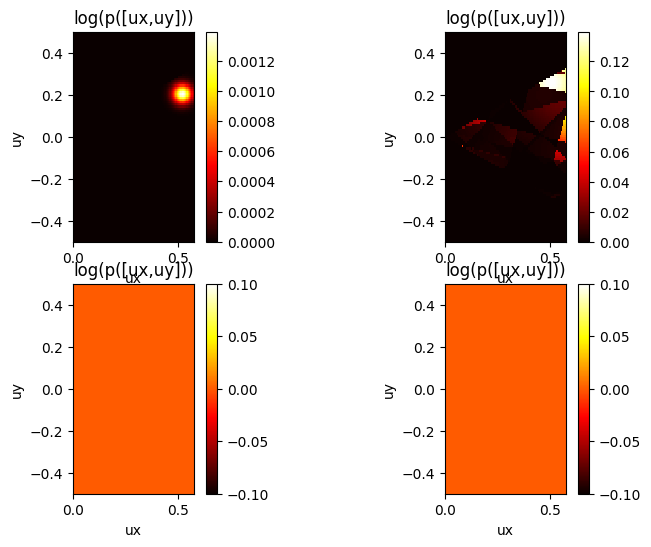

In [172]:
import matplotlib.pyplot as plt
data = np.load('loglikelihood_M5000_sigma.npz')
M_range = data['M_values']
sigma_range = data['sigma_values']
ux = data['uxs']
uy = data['uys']
ll = data['loglikelihood_functions']
# Create 3x2 subplots
fig, axs = plt.subplots(M_range.size, sigma_range.size,figsize = [8,6])
fig.subplots_adjust(wspace = 0.5)
for i in range(len(M_range)):
    for j in range(len(sigma_range)):
        ll_uxy = ll[i,j,:,:]/2/sigma_range[j]**2
        # vmax = np.amax(ll_uxy[ll_uxy<0.95e4])
        # vmin = np.amin(ll_uxy)
        # Plot data
        cmap = axs[i,j].imshow(np.flipud(np.exp(-ll_uxy.T)), cmap='hot', interpolation='none',
                            extent=[0,np.amax(ux),-0.5,0.5])
        fig.colorbar(cmap, ax=axs[i,j]) # Add a colorbar for the first subplot
        axs[i,j].set_title('log(p([ux,uy]))')
        axs[i,j].set_xlabel('ux')
        axs[i,j].set_ylabel('uy')


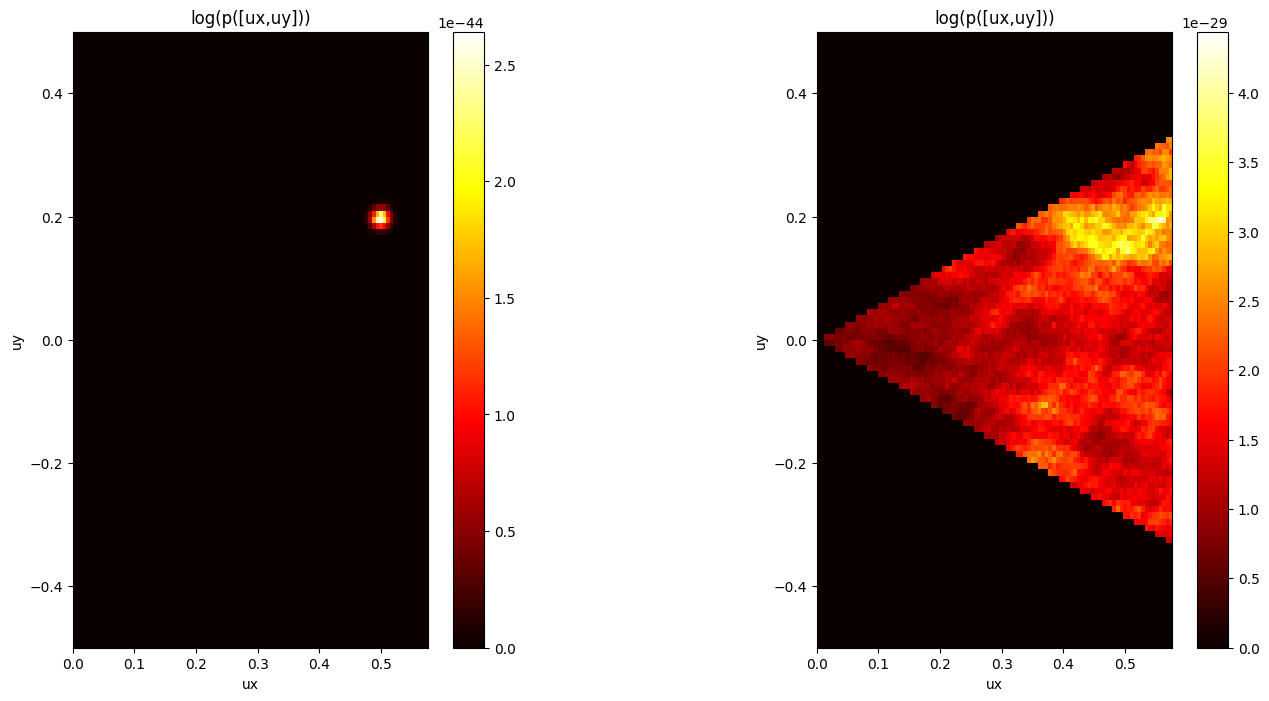

In [158]:
import matplotlib.pyplot as plt
data = np.load('loglikelihood_M_sigma_N100.npz')
M_range = data['M_values']
sigma_range = data['sigma_values']
ux = data['uxs']
uy = data['uys']
ll = data['loglikelihood_functions']
# Create 3x2 subplots
fig, axs = plt.subplots(1, sigma_range.size,figsize = [16,8])
fig.subplots_adjust(wspace = 0.5)
for j in range(len(sigma_range)):
    ll_uxy = np.mean(ll[:,j,:,:],axis=0)/2/sigma_values[j]**2
    # vmax = np.amax(ll_uxy[ll_uxy<0.95e4])
    # vmin = np.amin(ll_uxy)
    # Plot data
    cmap = axs[j].imshow(np.flipud(np.exp(-ll_uxy.T)), cmap='hot', interpolation='none',
                        extent=[0,np.amax(ux),-0.5,0.5])
    fig.colorbar(cmap, ax=axs[j]) # Add a colorbar for the first subplot
    axs[j].set_title('log(p([ux,uy]))')
    axs[j].set_xlabel('ux')
    axs[j].set_ylabel('uy')

In [10]:
import matplotlib.pyplot as plt
data = np.load('loglikelihood_M100_sigma_N.npz')
M = 100
sigma_range = data['sigma_values']
ux = data['uxs']
uy = data['uys']
ll = data['loglikelihood_functions']
N = ll.shape[0]
#linear part 1 to 10
linear_part = np.linspace(2,10,9)
#log part from 10 to 10000
steps = 50
log_part = np.round(np.logspace(np.log10(10),np.log10(5000),steps))
sampleSizes = np.unique(np.concatenate((linear_part, log_part)))
steps = len(sampleSizes)
ux_var_mean_lowRes = np.zeros([steps,len(sigma_range)])
uy_var_mean_lowRes = np.zeros([steps,len(sigma_range)])
ux_mean_mean_lowRes = np.zeros([steps,len(sigma_range)])
for _j, sigma in (enumerate(sigma_range)):
    for _i,sampleSize in enumerate(sampleSizes):
        ux_var = 0
        uy_var = 0
        ux_mean = 0
        sampleSize = int(sampleSize)
        for k in range(int(np.floor(N/sampleSize))):
            ll_uxy = np.sum(ll[k*sampleSize:(k+1)*sampleSize-1,_j,:,:],axis=0)
            ll_uxy -= np.amin(ll_uxy)
            likelihood = np.exp(-ll_uxy/2/(sigma**2))
            probability = likelihood/np.sum(likelihood)
            Uxs, Uys = np.meshgrid(uy, ux)
            ux_mean_sqr = np.sum(probability*Uxs**2)
            ux_mean = np.sum(probability*Uxs)
            ux_var = ux_var + (ux_mean_sqr - (ux_mean)**2)
            # Uy Variance
            uy_mean_sqr = np.sum(probability*Uys**2)
            uy_mean = np.sum(probability*Uys)
            uy_var = uy_var + (uy_mean_sqr - (uy_mean)**2)
        ux_var_mean_lowRes[_i,_j] = ux_var/k
        uy_var_mean_lowRes[_i,_j] = uy_var/k
        ux_mean_mean_lowRes[_i,_j] = ux_mean/k


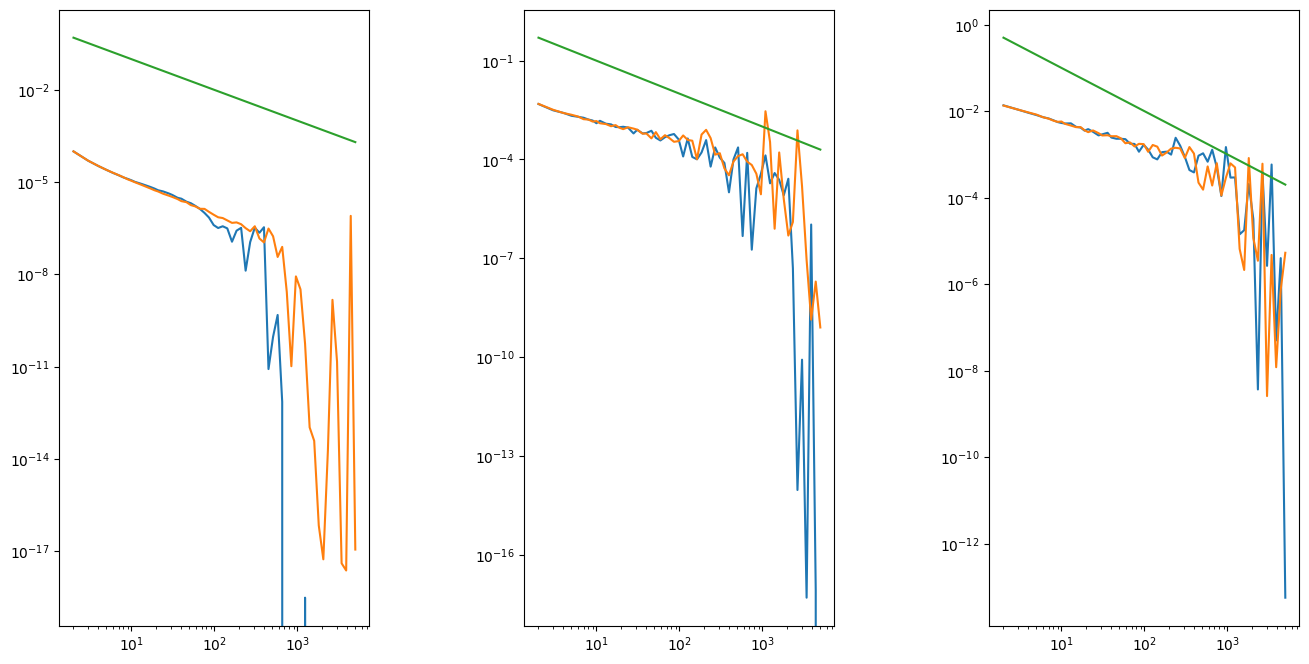

In [13]:
fig, axs = plt.subplots(1, sigma_range.size,figsize = [16,8])
fig.subplots_adjust(wspace = 0.5)
reference = 1/sampleSizes
for _j,sigma in (enumerate(sigma_range)):
    axs[_j].loglog(sampleSizes,ux_var_mean_lowRes[:,_j])
    axs[_j].loglog(sampleSizes,ux_var_mean[:,_j])
    axs[_j].loglog(sampleSizes,reference)

In [14]:
import matplotlib.pyplot as plt
data = np.load('loglikelihood_M100_sigma_N_highResolution.npz')
M = 100
sigma_range = data['sigma_values']
ux = data['uxs']
uy = data['uys']
ll = data['loglikelihood_functions']
N = ll.shape[0]

In [23]:
# Plot varaiance of ux variance as a function N when M = 100
#linear part 1 to 10
linear_part = np.linspace(2,10,9)
#log part from 10 to 10000
steps = 20
log_part = np.round(np.logspace(np.log10(10),np.log10(2000),steps))
sampleSizes = np.unique(np.concatenate((linear_part, log_part)))
# Total data points number
dataPoint = len(sampleSizes)

ux_var_mean = np.zeros([dataPoint,len(sigma_range)])
uy_var_mean = np.zeros([dataPoint,len(sigma_range)])
ux_mean_mean = np.zeros([dataPoint,len(sigma_range)])
ux_var_std = np.zeros([dataPoint,len(sigma_range)])
uy_var_std = np.zeros([dataPoint,len(sigma_range)])
for _j, sigma in (enumerate(sigma_range)):
    for _i,sampleSize in enumerate(sampleSizes):
        loopNumber = int(np.floor(N/sampleSize))
        ux_var = np.zeros([loopNumber,1])
        uy_var = np.zeros([loopNumber,1])
        ux_mean = np.zeros([loopNumber,1])
        sampleSize = int(sampleSize)
        for k in range(loopNumber):
            ll_uxy = np.sum(ll[k*sampleSize:(k+1)*sampleSize-1,_j,:,:],axis=0)
            ll_uxy -= np.amin(ll_uxy)
            likelihood = np.exp(-ll_uxy/2/(sigma**2))
            probability = likelihood/np.sum(likelihood)
            Uxs, Uys = np.meshgrid(uy, ux)
            ux_mean_sqr = np.sum(probability*Uxs**2)
            ux_mean[k] =  np.sum(probability*Uxs)
            ux_var[k] = (ux_mean_sqr - (ux_mean[k])**2)
            # Uy Variance
            uy_mean_sqr = np.sum(probability*Uys**2)
            uy_mean = np.sum(probability*Uys)
            uy_var[k] = (uy_mean_sqr - (uy_mean)**2)
        ux_var_mean[_i,_j] = np.mean(ux_var)
        uy_var_mean[_i,_j] = np.mean(uy_var)
        ux_mean_mean[_i,_j] = np.mean(ux_mean)
        ux_var_std[_i,_j] = np.std(ux_var)
        uy_var_std[_i,_j] = np.std(uy_var)

In [37]:
np.savez("result_M100_sigma_N_highResolution.npz", sigma_values=sigma_range, 
             sampleValues = sampleSizes, ux_variance_mean = ux_var_mean, uy_variance_mean = uy_var_mean, ux_variance_std = ux_var_std, uy_variance_std = uy_var_std)

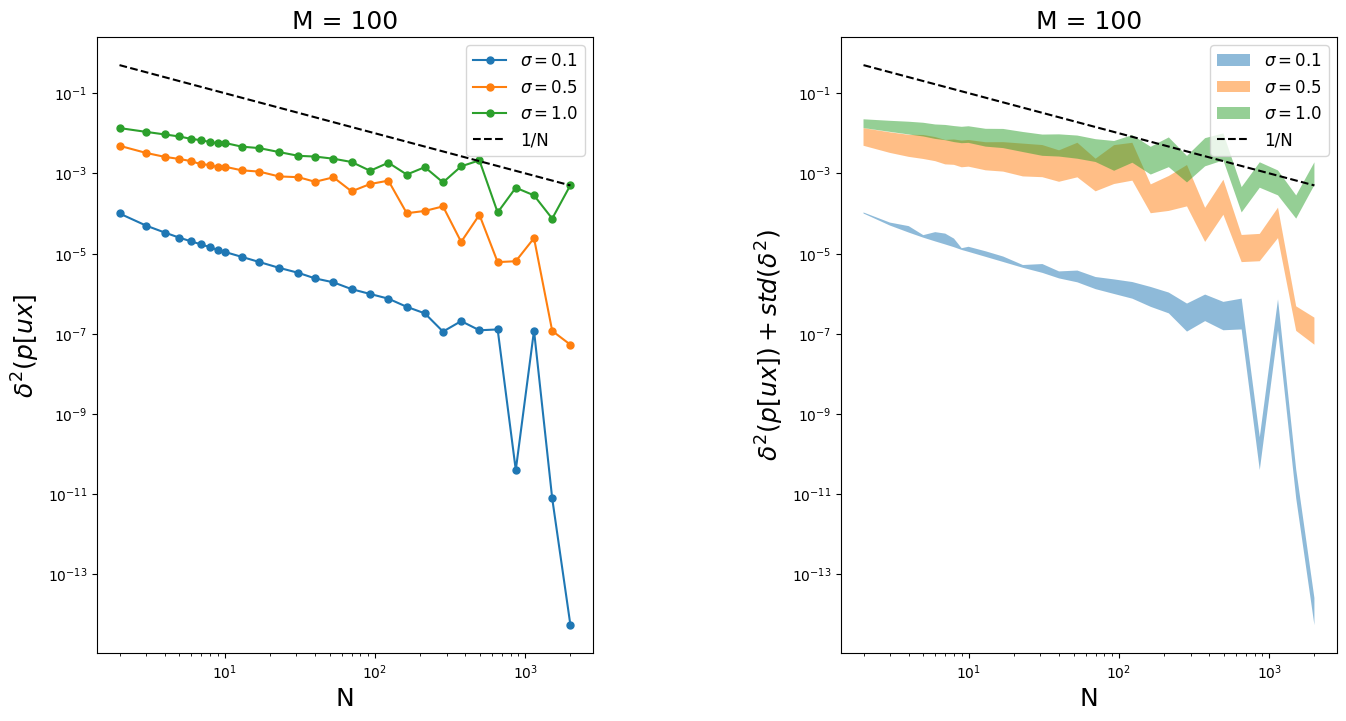

In [87]:
result_N_sigma = np.load("result_M100_sigma_N_highResolution.npz")
sigma_range = result_N_sigma['sigma_values']
sampleSizes = result_N_sigma['sampleValues']
ux_var_mean = result_N_sigma['ux_variance_mean']
uy_var_mean = result_N_sigma['uy_variance_mean']
ux_var_std = result_N_sigma['ux_variance_std']
fig, ax = plt.subplots(1, 2,figsize = [16,8])
fig.subplots_adjust(wspace = 0.5)
reference = 1/sampleSizes
for _j,sigma in (enumerate(sigma_range)):
    ax[0].loglog(sampleSizes,ux_var_mean[:,_j],label=f"$\sigma=${sigma}",marker='.',linestyle='-',markersize=10)
ax[0].loglog(sampleSizes,reference,'k--',label="1/N")
ax[0].set_title('M = 100',fontsize = 18)
ax[0].set_xlabel('N',fontsize = 18)
ax[0].set_ylabel(r'$\delta^2 (p[ux]$',fontsize = 18)
ax[0].legend(fontsize=12)
for _j,sigma in (enumerate(sigma_range)):
    # ax[1].loglog(sampleSizes,ux_var_mean[:,_j]+ux_var_std[:,_j],label=f"$\sigma=${sigma}",marker='.',linestyle='-',markersize=10)
    ax[1].fill_between(sampleSizes,ux_var_mean[:,_j],ux_var_mean[:,_j]+ux_var_std[:,_j],alpha = 0.5,label=f"$\sigma=${sigma}")
ax[1].plot(sampleSizes,reference,'k--',label="1/N")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('M = 100',fontsize = 18)
ax[1].set_xlabel('N',fontsize = 18)
ax[1].set_ylabel(r'$\delta^2 (p[ux])+std(\delta^2)$',fontsize = 18)
ax[1].legend(fontsize=12)

In [39]:
import matplotlib.pyplot as plt
data_sigmaSweep = np.load('loglikelihood_M100_sigma_N1000_highResolution.npz')
M = 100
sigma_range = data_sigmaSweep['sigma_values']
ux = data_sigmaSweep['uxs']
uy = data_sigmaSweep['uys']
ll = data_sigmaSweep['loglikelihood_functions']
N = ll.shape[0]

In [42]:
# Plot varaiance of ux variance as a function N when M = 100

# Total data points number

ux_var_mean = np.zeros([len(sigma_range),1])
uy_var_mean = np.zeros([len(sigma_range),1])
ux_mean_mean = np.zeros([len(sigma_range),1])
ux_var_std = np.zeros([len(sigma_range),1])
uy_var_std = np.zeros([len(sigma_range),1])
sampleSize = 10
for _j, sigma in (enumerate(sigma_range)):
    loopNumber = int(np.floor(N/sampleSize))
    ux_var = np.zeros([loopNumber,1])
    uy_var = np.zeros([loopNumber,1])
    ux_mean = np.zeros([loopNumber,1])
    sampleSize = int(sampleSize)
    for k in range(loopNumber):
        ll_uxy = np.sum(ll[k*sampleSize:(k+1)*sampleSize-1,_j,:,:],axis=0)
        ll_uxy -= np.amin(ll_uxy)
        likelihood = np.exp(-ll_uxy/2/(sigma**2))
        probability = likelihood/np.sum(likelihood)
        Uxs, Uys = np.meshgrid(uy, ux)
        ux_mean_sqr = np.sum(probability*Uxs**2)
        ux_mean[k] =  np.sum(probability*Uxs)
        ux_var[k] = (ux_mean_sqr - (ux_mean[k])**2)
        # Uy Variance
        uy_mean_sqr = np.sum(probability*Uys**2)
        uy_mean = np.sum(probability*Uys)
        uy_var[k] = (uy_mean_sqr - (uy_mean)**2)
    ux_var_mean[_j] = np.mean(ux_var)
    uy_var_mean[_j] = np.mean(uy_var)
    ux_mean_mean[_j] = np.mean(ux_mean)
    ux_var_std[_j] = np.std(ux_var)
    uy_var_std[_j] = np.std(uy_var)

Text(0, 0.5, 'ux')

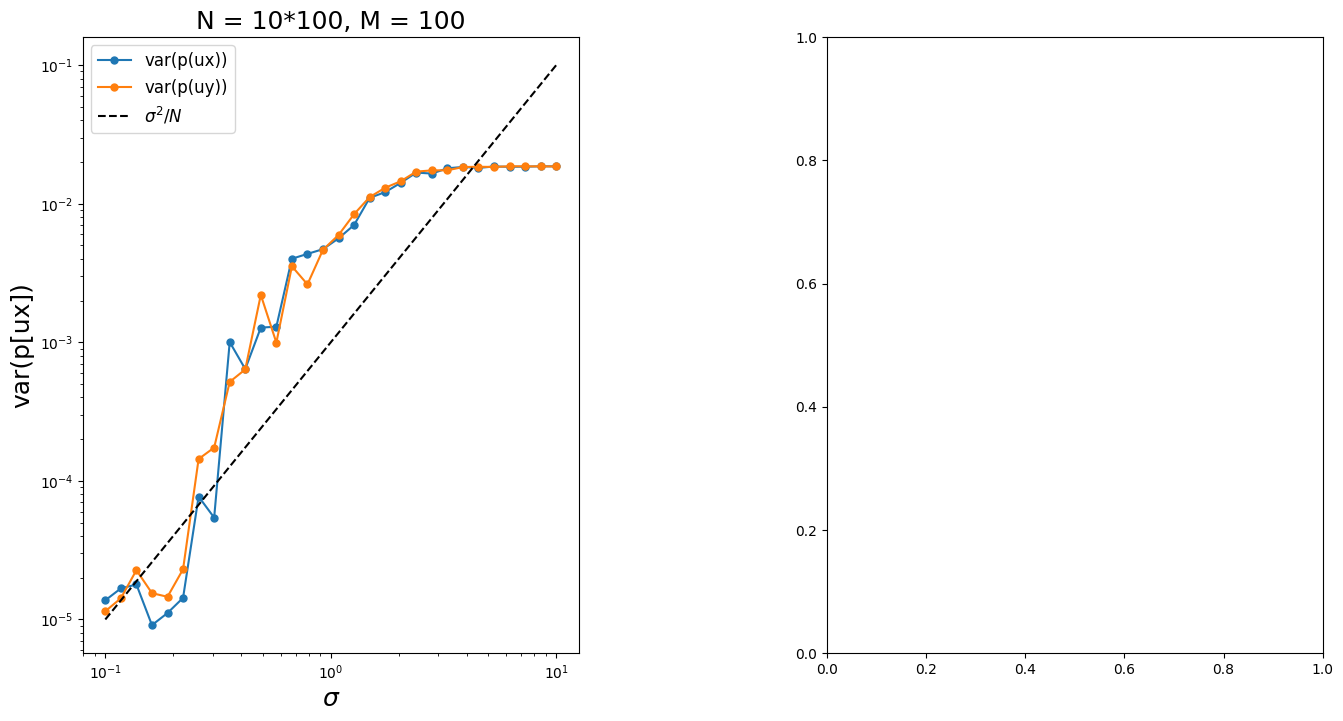

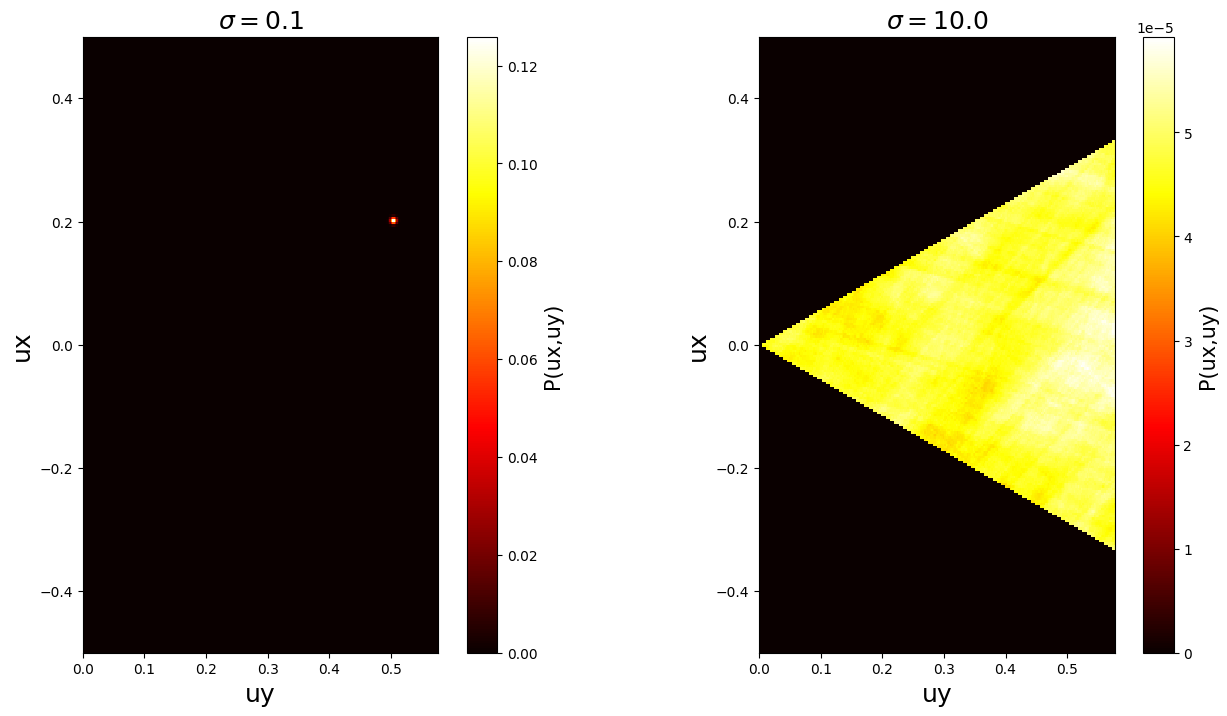

In [76]:
fig, ax = plt.subplots(1, 2,figsize = [16,8])
fig.subplots_adjust(wspace = 0.5)
reference = sigma_range ** 2/N
ax[0].loglog(sigma_range,ux_var_mean,marker='.',linestyle='-',markersize=10,label="var(p(ux))")
ax[0].loglog(sigma_range,uy_var_mean,marker='.',linestyle='-',markersize=10,label="var(p(uy))")
ax[0].loglog(sigma_range,reference,'k--',label=f"$\sigma^2/N$")
ax[0].set_title('N = 10*100, M = 100',fontsize = 18)
ax[0].set_xlabel(r'$\sigma$',fontsize = 18)
ax[0].set_ylabel('var(p[ux])',fontsize = 18)
ax[0].legend(fontsize=12)

fig, ax = plt.subplots(1, 2,figsize = [16,8])
fig.subplots_adjust(wspace = 0.2)
ll_uxy = np.sum(ll[0*sampleSize:(0+1)*sampleSize-1,0,:,:],axis=0)
ll_uxy -= np.amin(ll_uxy)
likelihood = np.exp(-ll_uxy/2/(sigma_range[0]**2))
probability = likelihood/np.sum(likelihood)
cmap = ax[0].imshow(np.flipud(probability.T), cmap='hot', interpolation='none',
                            extent=[0,np.amax(ux),-0.5,0.5])
fig.colorbar(cmap, ax=ax[0]).set_label('P(ux,uy)',fontsize=15) # Add a colorbar for the first subplot
ax[0].set_title(f'$\sigma=${sigma_range[0]}',fontsize = 18)
ax[0].set_xlabel('uy',fontsize = 18)
ax[0].set_ylabel('ux',fontsize = 18)

ll_uxy = np.sum(ll[0*sampleSize:(0+1)*sampleSize-1,len(sigma_range)-1,:,:],axis=0)
ll_uxy -= np.amin(ll_uxy)
likelihood = np.exp(-ll_uxy/2/(sigma_range[-1]**2))
probability = likelihood/np.sum(likelihood)
cmap = ax[1].imshow(np.flipud(probability.T), cmap='hot', interpolation='none',
                            extent=[0,np.amax(ux),-0.5,0.5])
fig.colorbar(cmap, ax=ax[1]).set_label('P(ux,uy)',fontsize=15) # Add a colorbar for the first subplot
ax[1].set_title(f'$\sigma=${sigma_range[-1]}',fontsize = 18)
ax[1].set_xlabel('uy',fontsize = 18)
ax[1].set_ylabel('ux',fontsize = 18)

In [99]:
import matplotlib.pyplot as plt
data_MSweep = np.load('loglikelihood_MSweep_sigma_N.npz')
sigma_range = data_MSweep['sigma_values']
M_range = data_MSweep['M_values'][0:11]
ux = data_MSweep['uxs']
uy = data_MSweep['uys']
ll = data_MSweep['loglikelihood_functions']
N = int(ll.shape[0]/len(M_range))

In [100]:
# Plot varaiance of ux variance as a function M when N = 23

# Total data points number

ux_var_mean = np.zeros([len(M_range),len(sigma_range)])
uy_var_mean = np.zeros([len(M_range),len(sigma_range)])
ux_mean_mean = np.zeros([len(M_range),len(sigma_range)])
# ux_var_std = np.zeros([len(M_range),len(sigma_range)])
# uy_var_std = np.zeros([len(M_range),len(sigma_range)])
for _j, sigma in (enumerate(sigma_range)):
    for _i,M in enumerate(M_range):
        index_of_interest = np.arange(start=_i,stop=_i+len(M_range)*N, step = len(M_range))
        ll_uxy = np.sum(ll[index_of_interest,:,:],axis=0)
        ll_uxy -= np.amin(ll_uxy)
        likelihood = np.exp(-ll_uxy/2/(sigma**2))
        probability = likelihood/np.sum(likelihood)
        Uxs, Uys = np.meshgrid(uy, ux)
        ux_mean_sqr = np.sum(probability*Uxs**2)
        ux_mean_mean[_i,_j] =  np.sum(probability*Uxs)
        ux_var_mean[_i,_j] = (ux_mean_sqr - (ux_mean[k])**2)
        # Uy Variance
        uy_mean_sqr = np.sum(probability*Uys**2)
        uy_mean = np.sum(probability*Uys)
        uy_var_mean[_i,_j]  = (uy_mean_sqr - (uy_mean)**2)
        # ux_var_std[_i,_j] = np.std(ux_var)
        # uy_var_std[_i,_j] = np.std(uy_var)

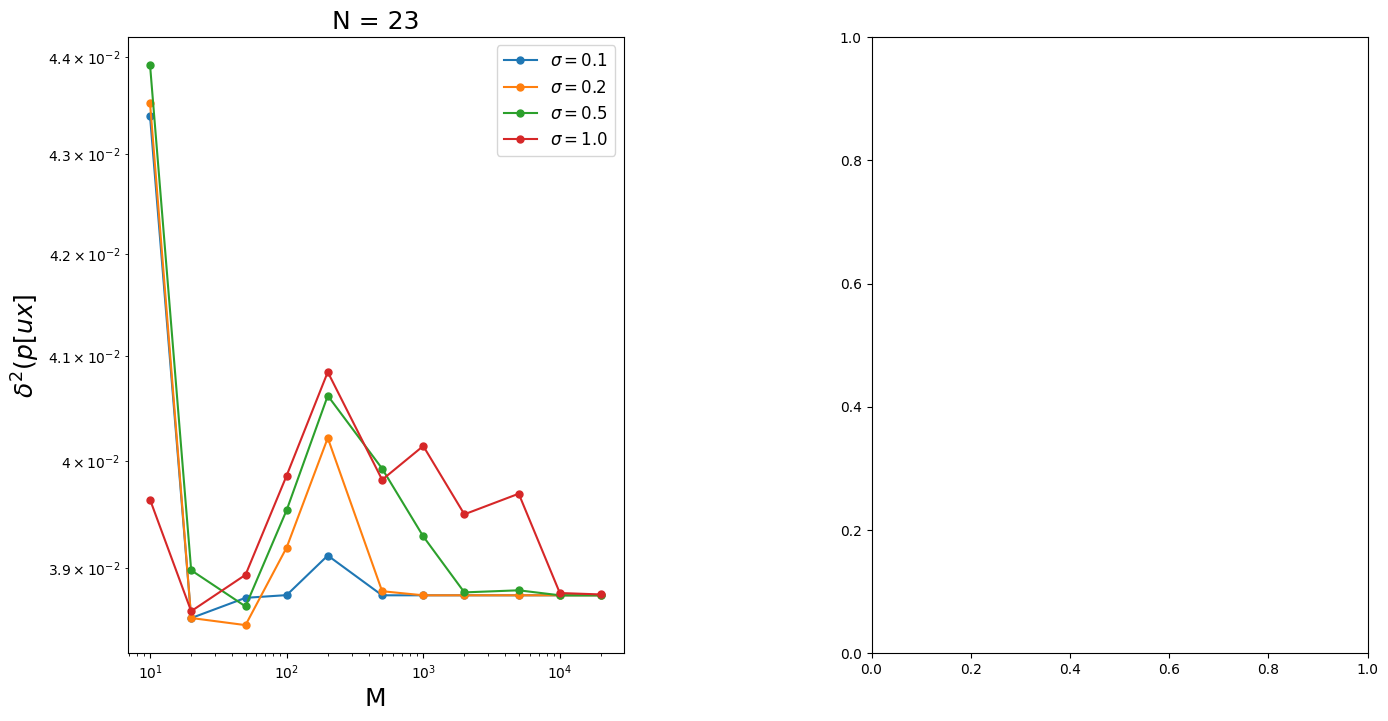

In [103]:
fig, ax = plt.subplots(1, 2,figsize = [16,8])
fig.subplots_adjust(wspace = 0.5)
reference = 1/M_range
for _j,sigma in (enumerate(sigma_range)):
    ax[0].loglog(M_range,ux_var_mean[:,_j],label=f"$\sigma=${sigma}",marker='.',linestyle='-',markersize=10)
# ax[0].loglog(M_range,reference,'k--',label="1/N")
ax[0].set_title('N = 23',fontsize = 18)
ax[0].set_xlabel('M',fontsize = 18)
ax[0].set_ylabel(r'$\delta^2 (p[ux]$',fontsize = 18)
ax[0].legend(fontsize=12)

# fig, ax = plt.subplots(1, 2,figsize = [16,8])
# fig.subplots_adjust(wspace = 0.2)
# ll_uxy = np.sum(ll[0*sampleSize:(0+1)*sampleSize-1,0,:,:],axis=0)
# ll_uxy -= np.amin(ll_uxy)
# likelihood = np.exp(-ll_uxy/2/(sigma_range[0]**2))
# probability = likelihood/np.sum(likelihood)
# cmap = ax[0].imshow(np.flipud(probability.T), cmap='hot', interpolation='none',
#                             extent=[0,np.amax(ux),-0.5,0.5])
# fig.colorbar(cmap, ax=ax[0]).set_label('P(ux,uy)',fontsize=15) # Add a colorbar for the first subplot
# ax[0].set_title(f'$\sigma=${sigma_range[0]}',fontsize = 18)
# ax[0].set_xlabel('uy',fontsize = 18)
# ax[0].set_ylabel('ux',fontsize = 18)

# ll_uxy = np.sum(ll[0*sampleSize:(0+1)*sampleSize-1,len(sigma_range)-1,:,:],axis=0)
# ll_uxy -= np.amin(ll_uxy)
# likelihood = np.exp(-ll_uxy/2/(sigma_range[-1]**2))
# probability = likelihood/np.sum(likelihood)
# cmap = ax[1].imshow(np.flipud(probability.T), cmap='hot', interpolation='none',
#                             extent=[0,np.amax(ux),-0.5,0.5])
# fig.colorbar(cmap, ax=ax[1]).set_label('P(ux,uy)',fontsize=15) # Add a colorbar for the first subplot
# ax[1].set_title(f'$\sigma=${sigma_range[-1]}',fontsize = 18)
# ax[1].set_xlabel('uy',fontsize = 18)
# ax[1].set_ylabel('ux',fontsize = 18)

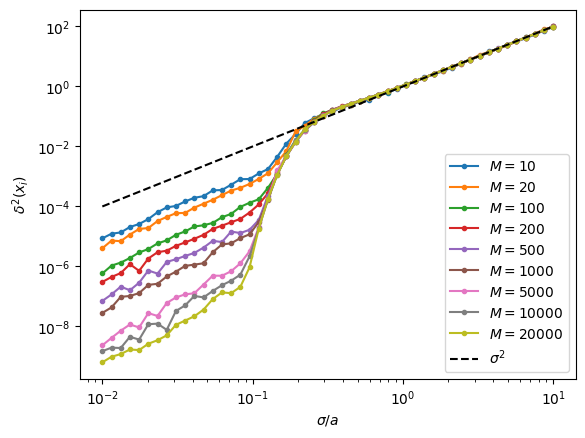

In [53]:
# Plot var(P)
import matplotlib.pyplot as plt
data_minimize = np.load('minimize_xi_sigma_M10.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
M = data_minimize['M_values']
# initiate 
x_var = np.zeros([len(sigma_range),9])
i = 0
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
plt.loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M}")
i += 1

data_minimize = np.load('minimize_xi_sigma_M20.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
plt.loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M}")
i += 1

data_minimize = np.load('minimize_xi_sigma_M100.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
plt.loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M}")
i += 1



data_minimize = np.load('minimize_xi_sigma_M200.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
plt.loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M}")
i += 1

data_minimize = np.load('minimize_xi_sigma_M500.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
plt.loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M}")
i += 1




data_minimize = np.load('minimize_xi_sigma_M1000.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
plt.loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M}")
i += 1




data_minimize = np.load('minimize_xi_sigma_M5000.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
plt.loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M}")
i += 1



data_minimize = np.load('minimize_xi_sigma_M10000.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
plt.loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M}")
i += 1

data_minimize = np.load('minimize_xi_sigma_M20000.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
plt.loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M}")



plt.loglog(sigma_range,sigma_range**2,'k--',label=f"$\sigma^2$")
plt.xlabel(r"$\sigma/a$")
plt.ylabel(f"$\delta^2(x_i)$")
plt.legend()
# plt.loglog(sigma_range,sigma_range**2/20,'g--')
# plt.loglog(sigma_range,sigma_range**2/10,'g--')
# plt.loglog(sigma_range,sigma_range**2/100,'g--')
# plt.loglog(sigma_range,sigma_range**2/200,'g--')
# plt.loglog(sigma_range,sigma_range**2/500,'g--')
# plt.loglog(sigma_range,sigma_range**2/1000,'g--')
# plt.loglog(sigma_range,sigma_range**2/5000,'g--')
# plt.loglog(sigma_range,sigma_range**2/10000,'g--')
# plt.loglog(sigma_range,sigma_range**2/20000,'g--')
# plt.axvline(0.28)
# plt.axvline(0.28/2)
# plt.scatter(predict_positions[:,i,0],predict_positions[:,i,1])

# plt.scatter(positions[i,0],positions[i,1])
# print(np.std(predict_positions[:,i,0]))

In [108]:
import matplotlib.pyplot as plt
stepNumber = 100
ll_uxy = np.zeros([stepNumber,stepNumber])
step_x = 0.007
step_y = 0.01

for i in range (stepNumber):
  for j in range(stepNumber):
    if (np.abs(0+step_x*i)/np.sqrt(3) - np.abs(-0.5+step_y*j))>0:
      ll_uxy[i,j] = log_likelihood((theta_true,0+step_x*i,-0.5+step_y*j))
    else:
      ll_uxy[i,j] = 10000

NameError: name 'step' is not defined

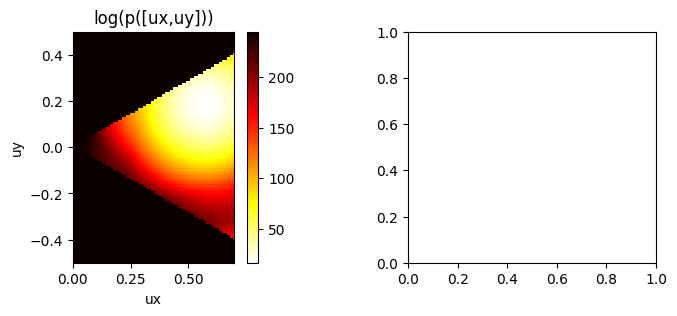

In [103]:
# Create 2x2 subplots
fig, axs = plt.subplots(1, 2,figsize = [8,3])
fig.subplots_adjust(wspace = 0.5)
vmax = np.amax(ll_uxy[ll_uxy<0.95e4])
vmin = np.amin(ll_uxy)
# Plot data
ux_range = np.arange(0, 0 + (stepNumber), 1)*step_x
uy_range = np.arange(0, 0 + (stepNumber), 1)*step_y
cmap = axs[0].imshow(np.flipud(ll_uxy.T), cmap='hot_r', interpolation='none',
                     extent=[0,0.7,-0.5,0.5],vmin = vmin, vmax = vmax)
fig.colorbar(cmap, ax=axs[0]) # Add a colorbar for the first subplot
axs[0].set_title('log(p([ux,uy]))')
axs[0].set_xlabel('ux')
axs[0].set_ylabel('uy')
axs[1].plot(np.arange(0, 0 + stepNumber * step, step), ll_theta)
axs[1].set_xlabel(r'$\theta$')
axs[1].set_ylabel(r'$log(p(theta))$')

/tmp/ipykernel_40847/3677262842.py:44: RuntimeWarning: Mean of empty slice
  d_mean[_i, i] = np.nanmean(d[_i], axis=(0, 1))  # Mean across all pairs (ignores NaNs)
/tmp/ipykernel_40847/3677262842.py:84: RuntimeWarning: Mean of empty slice
  d_mean[_i,i] = np.nanmean(d[_i],axis=(0,1))


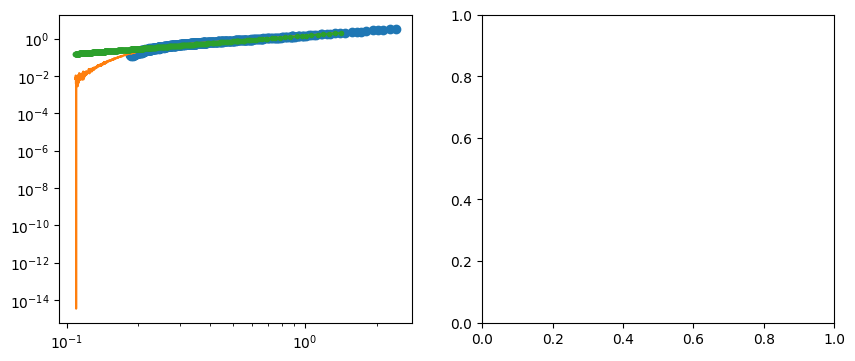

In [5]:
import matplotlib.pyplot as plt

# Create a figure with two subplots arranged horizontally
fig, ax = plt.subplots(1, 2, figsize=[10, 4])

# Initialize index for keeping track of the subplot
i = 0

# Load the experiment data from the file
data_minimize = np.load('diamond_minimize_xi_sigma_M10_returnMN_100Trail.npz')  # experimental data

# Extract necessary arrays from the loaded data
predict_positions = data_minimize['predicted_positions']  # Predicted positions of emitters
positions = data_minimize['original_positions']  # Actual positions of emitters
sigma_range = data_minimize['sigma_values']  # Noise levels (sigma values)
predicted_MN = data_minimize['predicted_MN']  # Predicted lattice points (m, n) for each emitter
M = data_minimize['M_values']  # Number of emitters

# Get the number of emitters for further calculations
N = M[0]

# Initialize arrays to store variance values between emitter pairs
d = np.full((len(sigma_range), N, N), np.nan)  # For storing distance variances between pairs
d_mean = np.zeros([len(sigma_range), 11])  # For storing mean variances for each sigma level
d_m = np.full((N, N), np.nan)  # For temporary variance calculations of m coordinates
d_m_mean = np.zeros([len(sigma_range), 11])  # For storing mean variances of m-coordinate distances

# Loop through each noise level (sigma) to compute distance variances
for _i, sigma in enumerate(sigma_range):
    # Loop over all emitter pairs (_j and _k) to calculate variance in distances
    for _j in range(M[0] - 1):
        for _k in range(_j + 1, M[0]):
            # Compute variance in the predicted lattice m-coordinate differences between pairs of emitters
            d_m[_j, _k] = np.var(predicted_MN[_i, :, _j, 0] - predicted_MN[_i, :, _k, 0])

            # Compute the Euclidean distance between emitter pairs based on predicted positions
            dist = np.sqrt(np.square(predict_positions[_i, :, _j, 0] - predict_positions[_i, :, _k, 0]) +
                           np.square(predict_positions[_i, :, _j, 1] - predict_positions[_i, :, _k, 1]))

            # Store the variance of the distances between the pairs
            d[_i, _j, _k] = np.var(dist)

    # Store the mean variance of all distances for this sigma level
    d_mean[_i, i] = np.nanmean(d[_i], axis=(0, 1))  # Mean across all pairs (ignores NaNs)

# Shape of the array for further analysis (m = sigma levels, n = number of emitter pairs)
m, _, n = d.shape

# Calculate the distances between the first and second emitters (example of pairwise distance)
distance = np.sqrt(np.square(predict_positions[:, :, 0, 0] - predict_positions[:, :, 1, 0]) +
                   np.square(predict_positions[:, :, 0, 1] - predict_positions[:, :, 1, 1]))

# Plot the square root of the mean variance for each noise level (sigma)
ax[0].loglog(sigma_range.ravel(), np.sqrt(d_mean[:, i]), 'o', label=f"$\sigma=${sigma}")

# Set x and y axes to logarithmic scale
ax[0].set_xscale("log")
ax[0].set_yscale("log")

# Update index for subplot tracking
i = i + 1


data_minimize = np.load('diamond_minimize_xi_sigma_M5_returnMN_10000Trail.npz') # experiment data
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']

N = M[0]
d = np.full((len(sigma_range),N,N),np.nan)

d_m = np.full((N,N),np.nan)

for _i,sigma in (enumerate(sigma_range)):
    for _j in range(M[0]-1):
        for _k in range(_j+1,M[0]):
        # for _k in range(1,2):
            d_m[_j,_k] = np.var(predicted_MN[_i,:,_j,0] - predicted_MN[_i,:,_k,0])
            dist = np.sqrt(np.square(predict_positions[_i,:,_j,0] - predict_positions[_i,:,_k,0])+np.square(predict_positions[_i,:,_j,1] - predict_positions[_i,:,_k,1]))
            d[_i,_j,_k] = np.var(dist)

    d_mean[_i,i] = np.nanmean(d[_i],axis=(0,1))
# m, _, n = d.shape
# ax[0].loglog(sigma_range, d[:,0,:].reshape(m, n),marker='.',label=f"$M=${M[0]}")
# Get the shape of the array
m, _, n = d.shape
distance = np.sqrt(np.square(predict_positions[:,:,0,0] - predict_positions[:,:,1,0])+np.square(predict_positions[:,:,0,1] - predict_positions[:,:,1,1]))


# ax[0].loglog(sigma_range, np.nanmean(d[:,0,:].reshape(m, n),1),marker='.',label=f"$M=${M[0]}")
ax[0].loglog(sigma_range.ravel(),np.sqrt(d_mean[:,i]),'-',label=f"$\sigma=${sigma}")
# ax[0].plot(sigma_range.ravel(),np.nanmean(dVarMean,1),'.')
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].loglog(sigma_range,sigma_range*np.sqrt(2),marker='.')